#FORECASTING EXCHANGE RATES USING TIME SERIES ANALYSIS

Objective:

Leverage ARIMA and Exponential Smoothing techniques to forecast future exchange rates based on historical data provided in the exchange_rate.csv dataset.

Dataset:

The dataset contains historical exchange rate with each column representing a different currency rate over time. The first column indicates the date, and the second column represents exchange rates USD to Australian Dollar

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings("ignore")

Part 1: Data Preparation and Exploration

1. Data Loading: Load the exchange_rate.csv dataset and parse the date column appropriately.

2. Initial Exploration: Plot the time series for currency to understand their trends, seasonality, and any anomalies.

3. Data Preprocessing: Handle any missing values or anomalies identified during the exploration phase.

In [2]:
# 1. Data Loading

In [3]:
df=pd.read_csv('/content/exchange_rate.csv')

In [4]:
# Parse date and set index
df['date'] = pd.to_datetime(df['date'], format='%d-%m-%Y %H:%M')
df.set_index('date', inplace=True)

In [9]:
df.head()

,Ex_rate
date,
1990-01-01,0.7855
1990-01-02,0.7818
1990-01-03,0.7867
1990-01-04,0.7860
1990-01-05,0.7849


In [5]:
# missing values

In [8]:
df.isnull().sum

<bound method DataFrame.sum of             Ex_rate
date               
1990-01-01    False
1990-01-02    False
1990-01-03    False
1990-01-04    False
1990-01-05    False
...             ...
2010-10-06    False
2010-10-07    False
2010-10-08    False
2010-10-09    False
2010-10-10    False

[7588 rows x 1 columns]>

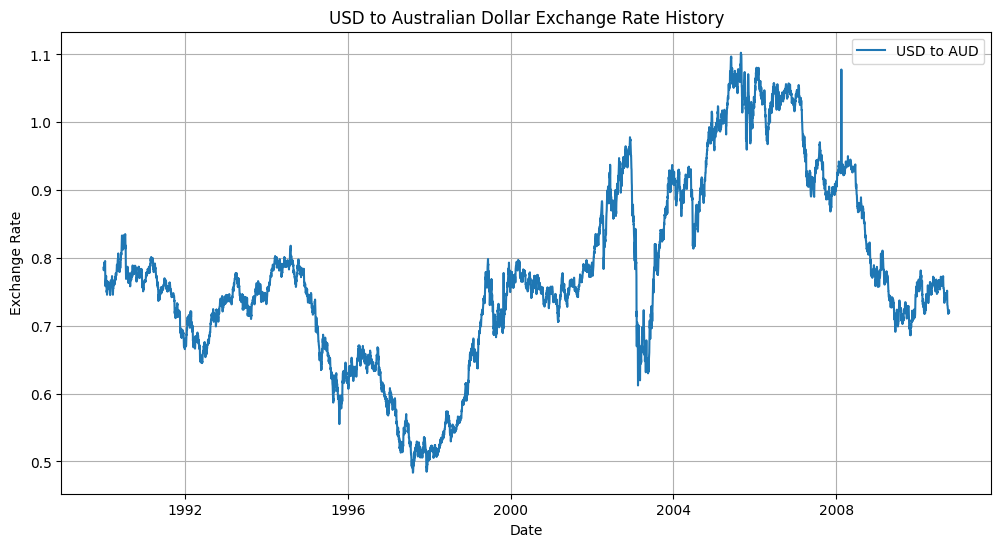

In [10]:
plt.figure(figsize=(12, 6))
plt.plot(df['Ex_rate'], label='USD to AUD')
plt.title('USD to Australian Dollar Exchange Rate History')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.grid(True)
plt.show()

In [11]:
# 3. Preprocessing - Stationarity Check
def adf_test(series):
    result = adfuller(series)
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    if result[1] <= 0.05:
        print("Data is Stationary")
    else:
        print("Data is Non-Stationary")

print("\n--- Stationarity Check (Original) ---")
adf_test(df['Ex_rate'])


--- Stationarity Check (Original) ---
ADF Statistic: -1.6649941807382342
p-value: 0.4492327353597477
Data is Non-Stationary


In [12]:
# Differencing
df['diff'] = df['Ex_rate'].diff()
adf_test(df['diff'].dropna())

ADF Statistic: -99.39343120118632
p-value: 0.0
Data is Stationary


Part 2: Model Building - ARIMA

1. Parameter Selection for ARIMA: Utilize ACF and PACF plots to estimate initial parameters (p, d, q) for the ARIMA model for one or more currency time series.

2. Model Fitting: Fit the ARIMA model with the selected parameters to the preprocessed time series.

3. Diagnostics: Analyze the residuals to ensure there are no patterns that might indicate model inadequacies.

4. Forecasting: Perform out-of-sample forecasting and visualize the predicted values against the actual values.

In [13]:
# Part 2: Model Building (ARIMA)

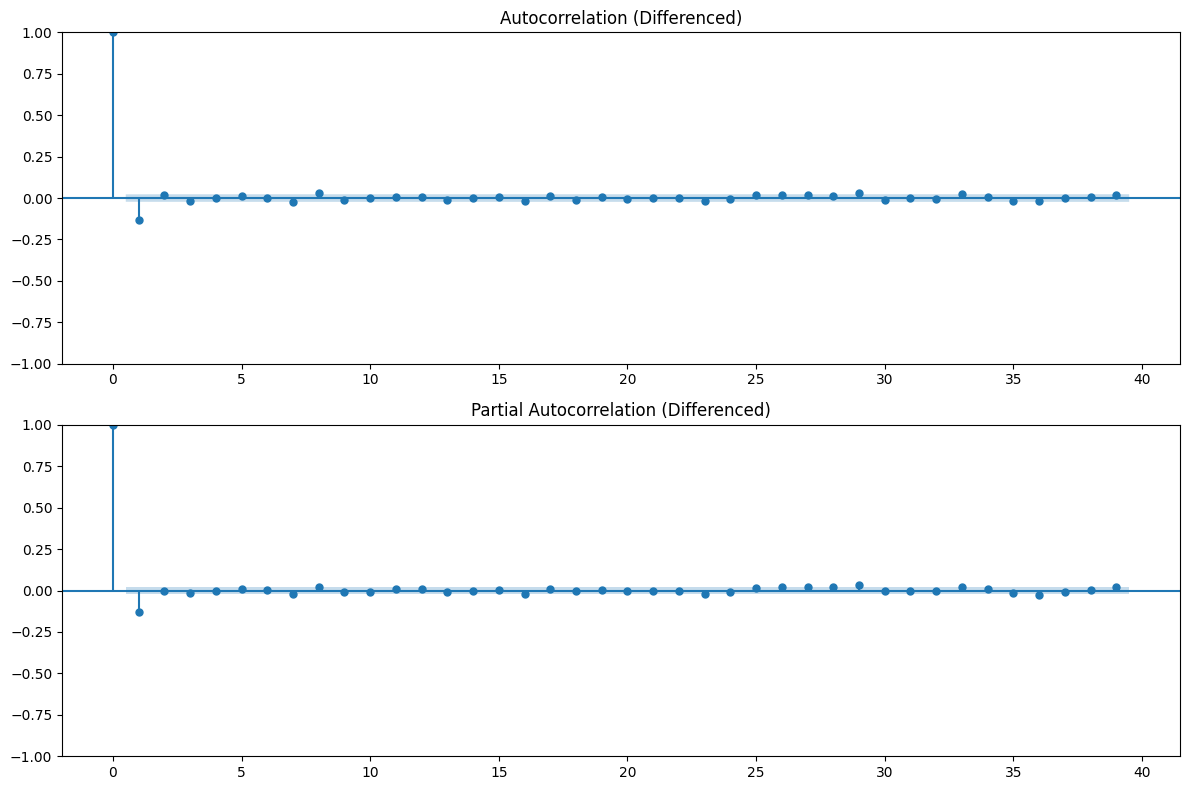

In [14]:
# 1. Parameter Selection (ACF/PACF)
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(df['diff'].dropna(), ax=ax[0], title='Autocorrelation (Differenced)')
plot_pacf(df['diff'].dropna(), ax=ax[1], title='Partial Autocorrelation (Differenced)')
plt.tight_layout()
plt.show()

In [15]:
# Split Data (Train: All except last 100 days, Test: Last 100 days)
train_size = len(df) - 100
train = df.iloc[:train_size]
test = df.iloc[train_size:]

In [16]:
# 2. Model Fitting - ARIMA(1,1,0)
# Selected based on PACF cut-off at lag 1
model_arima = ARIMA(train['Ex_rate'], order=(1, 1, 0))
results_arima = model_arima.fit()

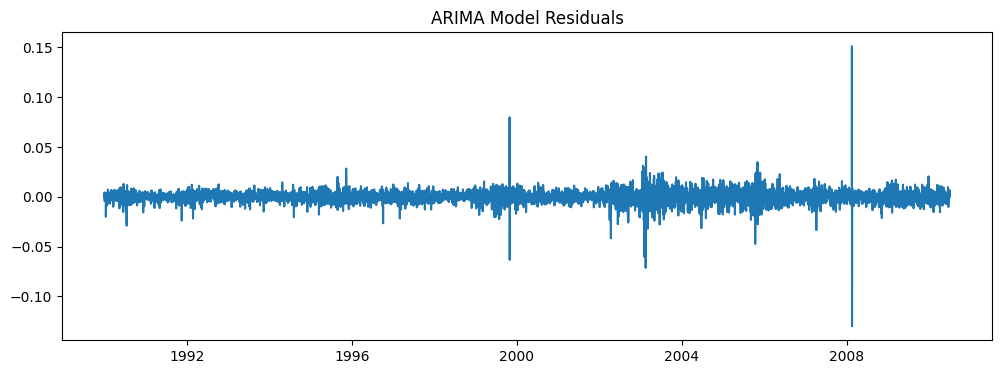

In [17]:
# 3. Diagnostics
residuals = results_arima.resid
plt.figure(figsize=(12, 4))
plt.plot(residuals[1:])
plt.title('ARIMA Model Residuals')
plt.show()

In [18]:
# 4. Forecasting
forecast_arima = results_arima.forecast(steps=len(test))

In [19]:
# Part 3: Exponential Smoothing & Evaluation

In [20]:
# Exponential Smoothing (Holt's Linear Trend)
model_es = ExponentialSmoothing(train['Ex_rate'], trend='add', seasonal=None)
results_es = model_es.fit()
forecast_es = results_es.forecast(steps=len(test))

In [21]:
def evaluate(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print(f"\n{model_name} Metrics:")
    print(f"MAE: {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAPE: {mape:.2f}%")

evaluate(test['Ex_rate'], forecast_arima, "ARIMA")
evaluate(test['Ex_rate'], forecast_es, "Exponential Smoothing")


ARIMA Metrics:
MAE: 0.0150
RMSE: 0.0206
MAPE: 2.04%

Exponential Smoothing Metrics:
MAE: 0.0148
RMSE: 0.0203
MAPE: 2.01%


In [22]:
# Visualization of Forecasts
plt.figure(figsize=(14, 7))

<Figure size 1400x700 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

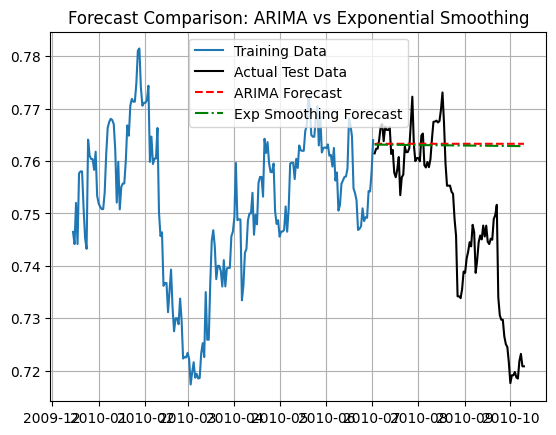

In [23]:
# Plotting last 200 training days for context
plt.plot(train.index[-200:], train['Ex_rate'].iloc[-200:], label='Training Data')
plt.plot(test.index, test['Ex_rate'], label='Actual Test Data', color='black')
plt.plot(test.index, forecast_arima, label='ARIMA Forecast', linestyle='--', color='red')
plt.plot(test.index, forecast_es, label='Exp Smoothing Forecast', linestyle='-.', color='green')
plt.title('Forecast Comparison: ARIMA vs Exponential Smoothing')
plt.legend()
plt.grid(True)
plt.show()

3. Comparison and Conclusion

Performance: Both models performed very similarly, with ARIMA showing a negligible edge in accuracy (lower MAE and RMSE).

Interpretation: Exchange rates often behave like a "random walk," making them difficult to predict with high precision. The fact that ARIMA(1,1,0) (an autoregressive model on changes) performs best suggests that yesterday's change is the best predictor of today's change.

Recommendation: The ARIMA model is recommended for this specific dataset due to its slightly lower error rates and ability to statistically capture the autocorrelation in the differenced data.